# Phase 2 - Préprocessing des données d'entrées

### Import des données

In [38]:
import pandas as pd
df=pd.read_csv('../Data/CO2 emissions from new passenger cars 2022.csv')

display(df.shape)

C:\Users\frederic.tudela\AppData\Local\Temp\ipykernel_27948\2535694952.py:2: DtypeWarning: Columns (3,8,10,12,28,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('../Data/CO2 emissions from new passenger cars 2022.csv')


(9479544, 40)

### filtrage initial
> 1) On ne garde que les véhicules FR et DE
> 2) Suppression des véhicules non poluants (Ft=Electric/hydrogen/unknown)


In [39]:
df.columns

Index(['ID', 'Country', 'VFN', 'Mp', 'Mh', 'Man', 'MMS', 'Tan', 'T', 'Va',
       'Ve', 'Mk', 'Cn', 'Ct', 'Cr', 'r', 'm (kg)', 'Mt', 'Enedc (g/km)',
       'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ft', 'Fm',
       'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'IT', 'Ernedc (g/km)',
       'Erwltp (g/km)', 'De', 'Vf', 'Status', 'year', 'Date of registration',
       'Fuel consumption ', 'ech', 'RLFI', 'Electric range (km)'],
      dtype='object')

In [40]:
df = df.loc[df.Country.isin({"FR", "DE"})]
df = df.loc[~df.Ft.isin({"electric", "hydrogen", "unknown"})]

display(df.shape)

(3528584, 40)

### Gestion des nans
> 1) Suppression des colonnes n'ayant que des nans
> 2) Suppression des colonnes à valeur unique

In [41]:
def dataframe_summary(df):
    data = []
    for col in df.columns:
        column_name = col
        nnan_rate = round(df[col].notna().mean()*100,2)
        nan_rate = round(df[col].isna().mean()*100,2)
        unique_values = df[col].nunique()
        column_type = df[col].dtype
        data.append([column_name, nnan_rate, nan_rate, unique_values, column_type])
    summary_df = pd.DataFrame(data, columns=['Colonne', 'Taux_nnan','Taux_nan', 'Valeurs_uniques', 'Type'])
    return summary_df

df_summary = dataframe_summary(df)

In [42]:
#Suppression des colonnes avec plus de 80% de valeurs manquantes 
col_a_suppr  = (df_summary.loc[(df_summary['Taux_nan']>80)]['Colonne']).to_list()

#Suppression des colonnes avec une seule valeur
col_a_suppr += (df_summary.loc[(df_summary['Taux_nnan']==100) & (df_summary['Valeurs_uniques']==1)]['Colonne']).to_list()

display(col_a_suppr)


['MMS',
 'Enedc (g/km)',
 'z (Wh/km)',
 'Ernedc (g/km)',
 'De',
 'Vf',
 'ech',
 'RLFI',
 'Electric range (km)',
 'r',
 'Status',
 'year']

In [43]:
df = df.drop(columns = col_a_suppr)
display(df.shape)


(3528584, 28)

### Suppression des lignes pour laquelle la variable cible est nulle

In [44]:
df = df.dropna(subset=['Ewltp (g/km)'])
display(df.shape)

(3522317, 28)

### Recherche des colonnes fortement correlées

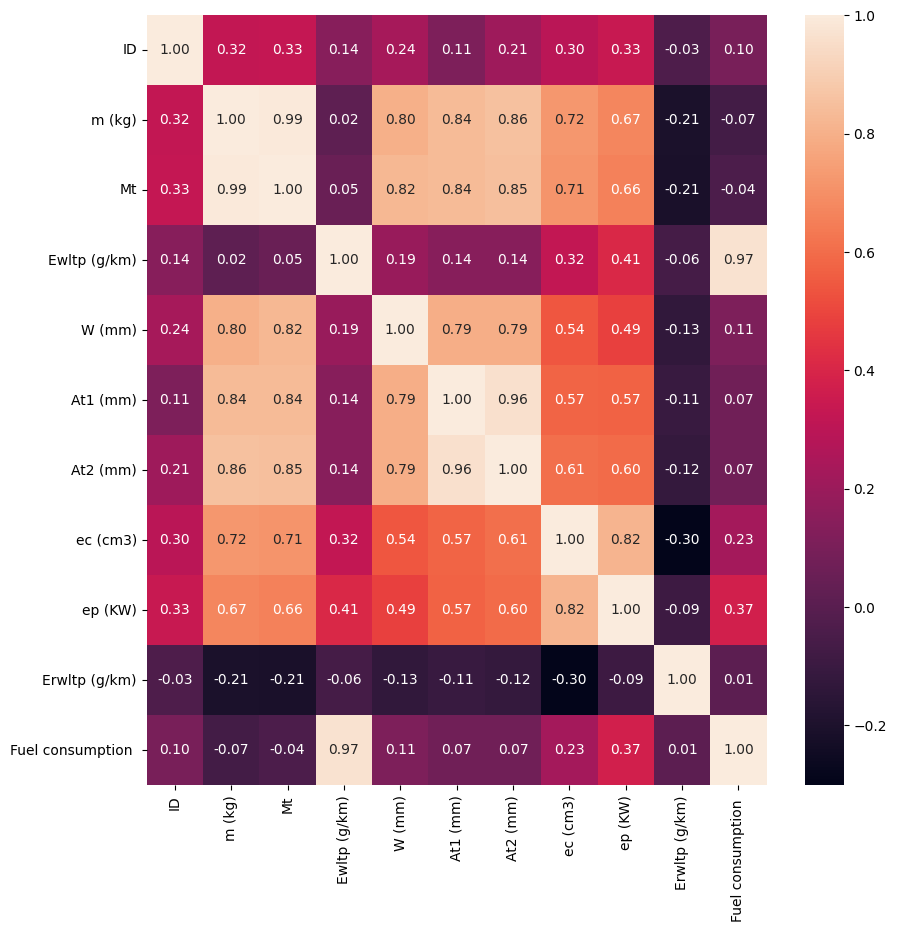

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(df.select_dtypes(['int64', 'float64']).corr(), annot=True, fmt=".2f");


> Suppression des colonne Mt et At2 redondantes avec les colonnes m (kg) et At1

In [48]:
df.drop(columns=["Mt", "At2 (mm)"], inplace=True)

> Suppression de la colonne Erwltp (g/km)

In [46]:
df.drop(columns=["Erwltp (g/km)"], inplace=True)

### Remplacement des nans des variables numériques par l'algo KNN

In [49]:
col_num = df.select_dtypes(["int64", "float64"]).columns

df[col_num].isna().sum()

ID                       0
m (kg)                   1
Ewltp (g/km)             0
W (mm)                6696
At1 (mm)              6747
ec (cm3)                 4
ep (KW)                  2
Fuel consumption     16495
dtype: int64

In [50]:
df_summary = dataframe_summary(df)
col_a_traiter  = (df_summary.loc[(df_summary.Type.isin({'float64', 'int64'}))]['Colonne']).to_list()
display(col_a_traiter)


['m (kg)',
 'Ewltp (g/km)',
 'W (mm)',
 'At1 (mm)',
 'ec (cm3)',
 'ep (KW)',
 'Fuel consumption ']

In [51]:
df[col_a_traiter].isna().sum()

m (kg)                   1
Ewltp (g/km)             0
W (mm)                6696
At1 (mm)              6747
ec (cm3)                 4
ep (KW)                  2
Fuel consumption     16495
dtype: int64

In [52]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df[col_a_traiter] = imputer.fit_transform(df[col_a_traiter])

df[col_a_traiter].isna().sum()

m (kg)               0
Ewltp (g/km)         0
W (mm)               0
At1 (mm)             0
ec (cm3)             0
ep (KW)              0
Fuel consumption     0
dtype: int64

In [53]:
# Enregistrement intermédiaire 
df.to_csv('../Data/Co2_int.csv', sep=',', index=False)